# Cover

## Imports

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

# For RFE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Accuracy Score
from sklearn.metrics import accuracy_score

# Train Test Split
from sklearn.model_selection import train_test_split

## Reading CSV

In [2]:
df = pd.read_csv("log2.csv")

## Structure of the Dataset

In [3]:
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,Action
0,57222,53,54587,53,177,94,83,2,30,1,1,allow
1,56258,3389,56258,3389,4768,1600,3168,19,17,10,9,allow
2,6881,50321,43265,50321,238,118,120,2,1199,1,1,allow
3,50553,3389,50553,3389,3327,1438,1889,15,17,8,7,allow
4,50002,443,45848,443,25358,6778,18580,31,16,13,18,allow


## Data Understanding

- Action is the Dependent Variable, while the others columns are independent variables;
- The dataset has 65k+ rows and 12 columns;
- No null values;
- 8k+ duplicated rows (that weren't dropped because some info or pattern can be lost with it);

In [4]:
df.describe()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.000000,65532.000000,65532.000000,65532.000000,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,49391.969343,10577.385812,19282.972761,2671.049930,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,15255.712537,18466.027039,21970.689669,9739.162278,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,0.000000,0.000000,0.000000,0.000000,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,49183.000000,80.000000,0.000000,0.000000,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,53776.500000,445.000000,8820.500000,53.000000,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,58638.000000,15000.000000,38366.250000,443.000000,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,65534.000000,65535.000000,65535.000000,65535.000000,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


In [5]:
df.shape

(65532, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Bytes                 65532 non-null  int64 
 5   Bytes Sent            65532 non-null  int64 
 6   Bytes Received        65532 non-null  int64 
 7   Packets               65532 non-null  int64 
 8   Elapsed Time (sec)    65532 non-null  int64 
 9   pkts_sent             65532 non-null  int64 
 10  pkts_received         65532 non-null  int64 
 11  Action                65532 non-null  object
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


In [7]:
df.isnull().sum()

Source Port             0
Destination Port        0
NAT Source Port         0
NAT Destination Port    0
Bytes                   0
Bytes Sent              0
Bytes Received          0
Packets                 0
Elapsed Time (sec)      0
pkts_sent               0
pkts_received           0
Action                  0
dtype: int64

In [8]:
df.duplicated().sum() # remove duplicated rows?

8362

## Dummy Encoding of column Action

To work with the Action Column we need it to be type bool instead of type object.

In [9]:
df_encoded = pd.get_dummies(df, columns=['Action'])

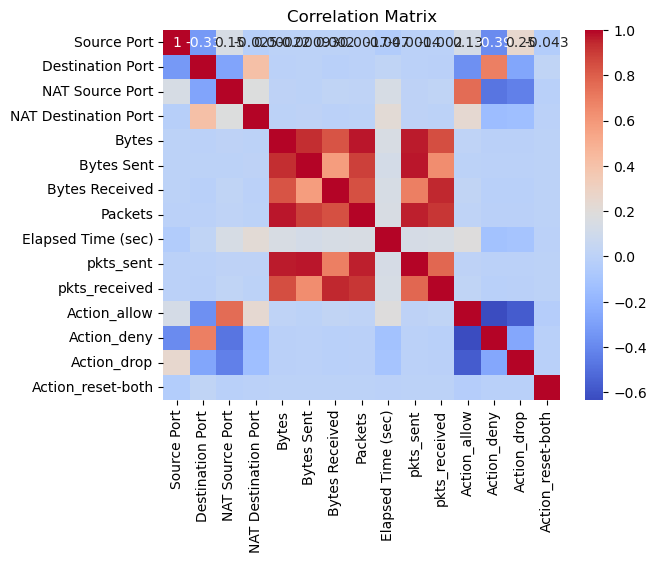

In [10]:
correlation_matrix = df_encoded.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Looking for outliers

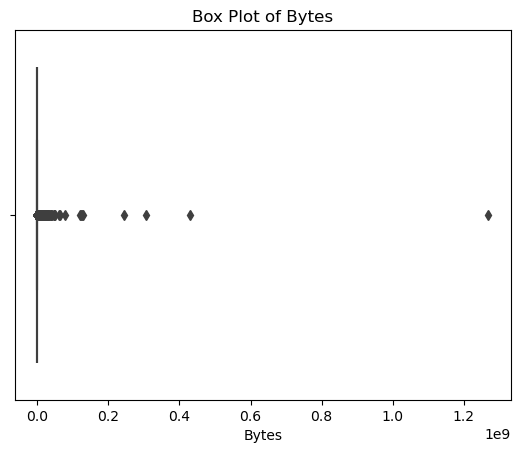

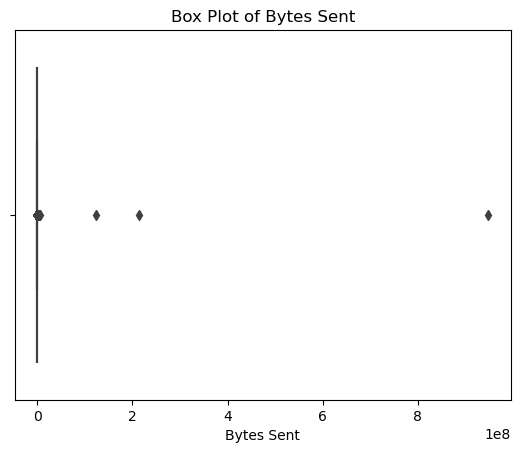

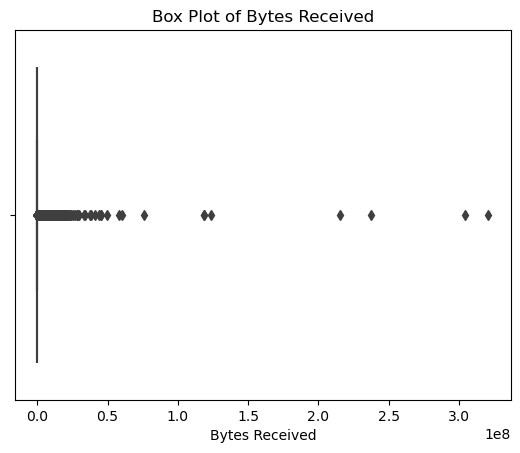

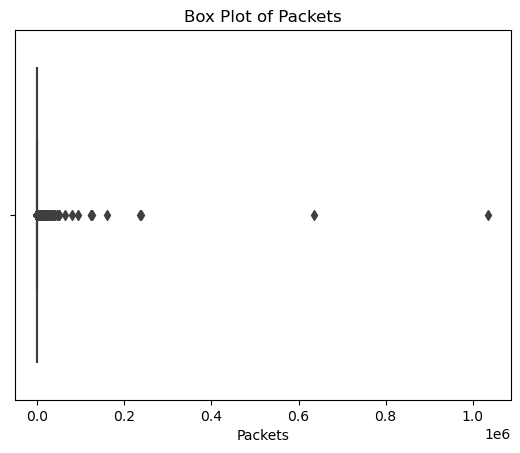

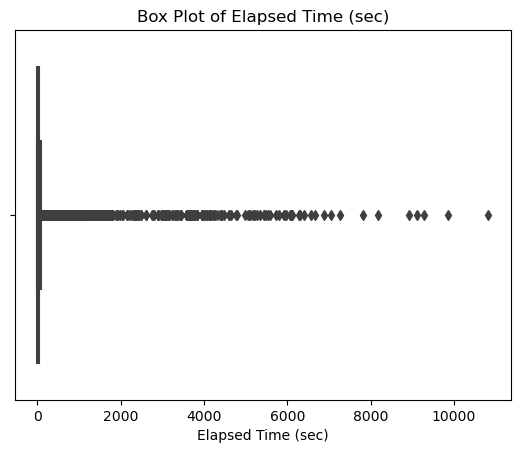

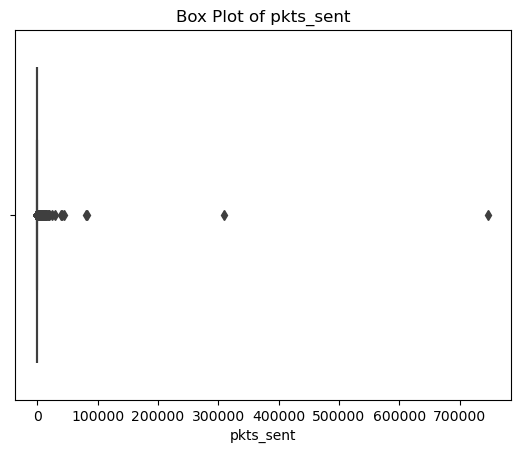

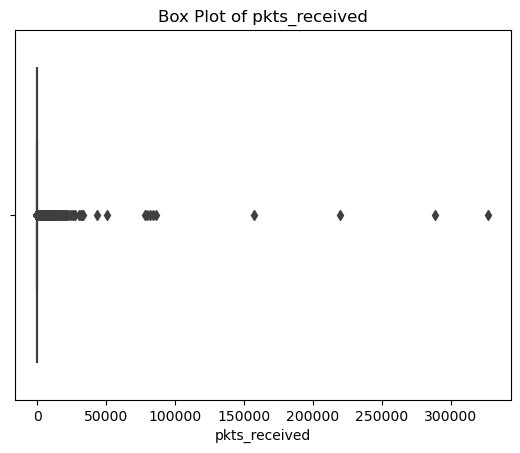

In [11]:
numerical_columns = ['Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received']

for column in numerical_columns:
    sns.boxplot(x=column, data=df_encoded)
    plt.xlabel(column)
    plt.title(f'Box Plot of {column}')
    plt.show()

## Treating Bytes

Here we will remove some of the outliers. Below there are the most frequents Bytes values on this dataset.

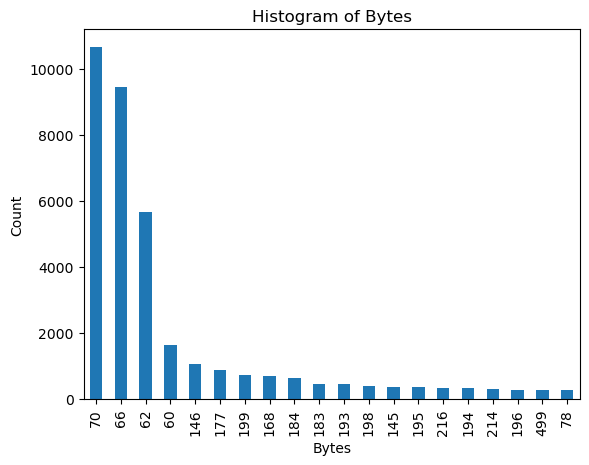

In [12]:
df['Bytes'].value_counts(ascending=False).head(20).plot(kind='bar')
plt.xlabel('Bytes')
plt.ylabel('Count')
plt.title('Histogram of Bytes')
plt.show()

We can see in the Boxplot of Bytes 4 data points that are outling and can affect our results, so we will drop all the values above a certain range (200 million bytes). This will prevent that the outlining values influence any of our predictions. We should do this with all the numerical columns.

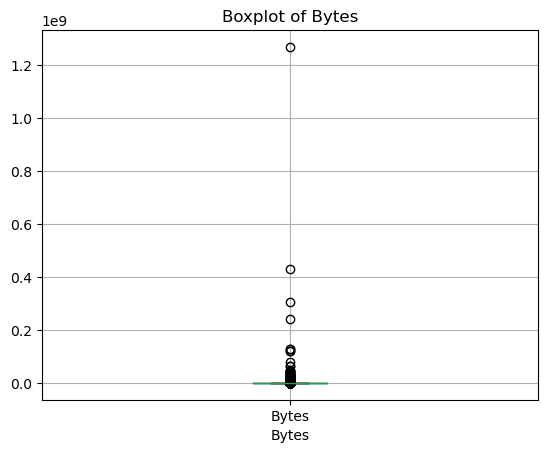

In [13]:
df.boxplot(column='Bytes')
plt.title('Boxplot of Bytes')
plt.xlabel('Bytes')
plt.show()

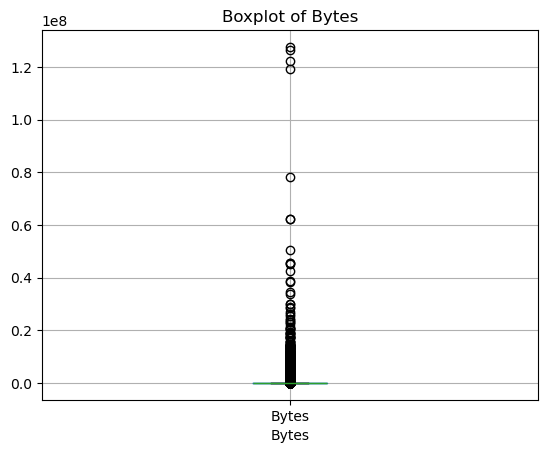

In [14]:
df.drop(df[df['Bytes'] > 200000000].index, inplace=True)

df.boxplot(column='Bytes')
plt.title('Boxplot of Bytes')
plt.xlabel('Bytes')
plt.show()

In [15]:
df.shape

(65528, 12)

As you can compare the initial shape was 65532 and now it's 65528. Only 4 rows were dropped.

------------------------------------------

## Treating Bytes Sent

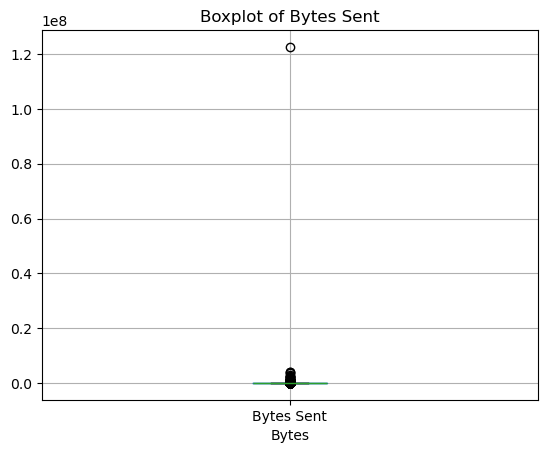

In [16]:
df.boxplot(column='Bytes Sent')
plt.title('Boxplot of Bytes Sent')
plt.xlabel('Bytes')
plt.show()

In [17]:
df['Bytes Sent'].max()

122661116

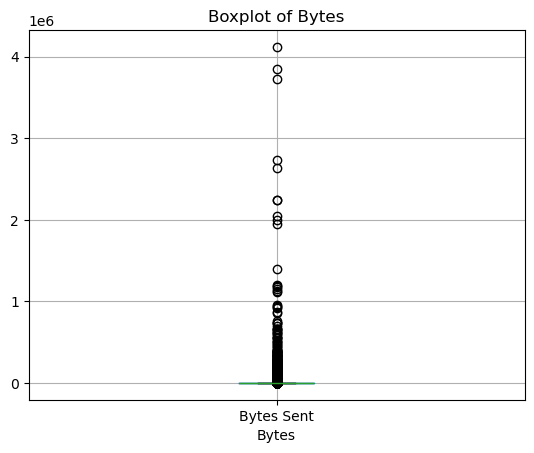

In [18]:
df.drop(df[df['Bytes Sent'] > 100000000].index, inplace=True)

df.boxplot(column='Bytes Sent')
plt.title('Boxplot of Bytes')
plt.xlabel('Bytes')
plt.show()

--------------------

In [19]:
#RFE feature elimination method - this helps on selecting which features should be used for model building
# chi-square test which columns to use in the model

#Ideas of Algorithm
#RandomForest
#XGBoost
#KNN


In [20]:
model = RandomForestClassifier()
X = df.drop(columns=['Action'])
y = df['Action']


rfe = RFE(model, n_features_to_select=5)
rfe.fit(X, y)

selected_features = pd.DataFrame({'Feature': X.columns, 'Selected': rfe.support_, 'Rank': rfe.ranking_})
print("Selected Features:")
print(selected_features[selected_features['Selected']])

Selected Features:
                Feature  Selected  Rank
1      Destination Port      True     1
2       NAT Source Port      True     1
3  NAT Destination Port      True     1
4                 Bytes      True     1
8    Elapsed Time (sec)      True     1


## Random Forest

In [21]:
X = df[['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port', 'Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received']]
y = df['Action']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9983213795208301


In [22]:
len(X_train)

52421

In [23]:
len(X_test)

13106

In [24]:
X = df[['Destination Port', 'NAT Source Port', 'NAT Destination Port', 'Bytes', 'Elapsed Time (sec)']]
y = df['Action']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9988554860369296


## KNN

In [25]:
X = df[['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port', 'Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received']]
y = df['Action']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.993361819014192
